# Tổng quan dự án

Phát hiện đăng nhập bất thường với Học máy

## Project Overview
Project này tập trung vào áp dụng học máy để phát hiện hành vi đăng nhập bất thường vào hệ thống CNTT

## Dataset Description
Dựa vào bộ dữ liệu đã được kiểm chứng, thử nghiệm trước đó, bao gồm các đặc điểm như ID người dùng, trạng thái đăng nhập, địa chỉ IP, loại thiết bị và thời lượng phiên.

## Objectives
- Cải tiến mô hình học máy, cụ thể tập trung vào LR và SVM.
- Export mô hình học máy và inject vào project cụ thể.

# Cài đặt và cấu hình

In [41]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


seed = 50
np.random.seed(seed)

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set(style="whitegrid")

print("Setup complete.")


Setup complete.


# Bộ dữ liệu

Bộ dữ liệu bao gồm các thuộc tính sau:

- **User ID**: Đại diện cho từng người dùng riêng lẻ trong hệ thống, mỗi người có những mẫu hành vi đặc trưng khác nhau.

- **Timestamps**: Được tạo để bao phủ toàn bộ một năm, cung cấp ngữ cảnh thời gian cho mỗi phiên làm việc.

- **Login Status**: Cho biết một lần đăng nhập là thành công hay thất bại. Đặc trưng này rất quan trọng, vì các lần đăng nhập thất bại có thể là dấu hiệu mạnh của những nỗ lực truy cập trái phép.

- **IP Addresses**: Bao gồm cả các địa chỉ IP phổ biến và không phổ biến. Sự đa dạng của địa chỉ IP giúp phân biệt giữa các lần đăng nhập bình thường của người dùng và các nỗ lực có khả năng là độc hại từ những vị trí hiếm hoặc bất thường.

- **Device Types**: Phản ánh sự đa dạng của các thiết bị có thể truy cập hệ thống, chẳng hạn như máy tính để bàn, điện thoại di động và máy tính bảng.

- **Locations**: Đo lường khoảng thời gian mà một phiên làm việc được duy trì hoạt động.

- **Session Duration**: Đo lường khoảng thời gian mà một phiên làm việc được duy trì hoạt động.

- **Failed Attempts**: Đếm số lần đăng nhập không thành công trong một phiên. Số lượng lớn các lần thất bại có thể báo hiệu một cuộc tấn công brute force hoặc các hoạt động độc hại khác.

- **Behavioral Scores**: Các điểm số định lượng được gán dựa trên hành vi của người dùng trong suốt một phiên làm việc.

- **Anomaly Labels**: Được suy ra từ các điều kiện định nghĩa trước dựa trên những đặc trưng khác, chẳng hạn như thời lượng phiên quá dài, số lần đăng nhập thất bại cao, điểm hành vi quá thấp hoặc quá cao, và các lần đăng nhập từ IP hiếm hoặc vị trí bất thường.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
#read from csv
import pandas as pd
file_path = '/content/drive/MyDrive/5-THESIS/Web_Auth_Anomaly_Detection/data/synthetic_web_auth_logs.csv'

df = pd.read_csv(file_path, parse_dates=['Timestamp'])
df.head()

,User ID,Timestamp,Login Status,IP Address,Device Type,Location,Session Duration,Failed Attempts,Behavioral Score,Anomaly
0,689,2024-08-04 07:27:08,Success,192.168.1.14,Desktop,Canada,7.44,0,88.55,0
1,481,2024-08-04 07:28:08,Success,192.168.1.25,Mobile,Germany,400.52,0,92.30,0
2,908,2024-08-04 07:29:08,Success,192.168.1.54,Tablet,Canada,298.02,0,81.04,0
3,110,2024-08-04 07:30:08,Success,192.168.1.27,Mobile,USA,0.02,0,97.93,1
4,290,2024-08-04 07:31:08,Success,192.168.1.27,Mobile,Germany,409.53,0,71.39,0


# Phân tích dữ liệu

In [44]:
# Kiểm tra những trường hợp bị thiếu thông tin
df.info()

print("\n Thông tin bị thiếu mỗi cột:\n", df.isnull().sum())
print("\n Thông kê theo Anomaly Status:")
print(df.groupby('Anomaly').describe())

# Tỷ lệ bất thường
print("\n Tỷ lệ Anomaly (%):")
print(df['Anomaly'].value_counts(normalize=True) * 100)

# Kiểm tra quan hệ giữa các feature
df_temp = df.copy()
df_temp['Login Status'] = df_temp['Login Status'].map({'Success': 1, 'Fail': 0})
correlation_matrix = df_temp.select_dtypes(include=[np.number]).corr()
print("\n Ma trận tương quan:\n", correlation_matrix)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   User ID           10000 non-null  int64         
 1   Timestamp         10000 non-null  datetime64[ns]
 2   Login Status      10000 non-null  object        
 3   IP Address        10000 non-null  object        
 4   Device Type       10000 non-null  object        
 5   Location          10000 non-null  object        
 6   Session Duration  10000 non-null  float64       
 7   Failed Attempts   10000 non-null  int64         
 8   Behavioral Score  10000 non-null  float64       
 9   Anomaly           10000 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 781.4+ KB

 Thông tin bị thiếu mỗi cột:
 User ID             0
Timestamp           0
Login Status        0
IP Address          0
Device Type         0
Location            

Tất cả 10 thuộc tính trong tập dữ liệu đều có 10.000 mục không rỗng. Các thuộc tính này sử dụng nhiều kiểu dữ liệu khác nhau, bao gồm số nguyên, số thập phân, chuỗi ký tự và ngày giờ, để thể hiện chính xác chi tiết mỗi lần đăng nhập. Ngoài ra, có thể thấy rằng khoảng 18,15% số lần đăng nhập được đánh dấu là bất thường.

# Trực quan dữ liệu

/tmp/ipython-input-903842323.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


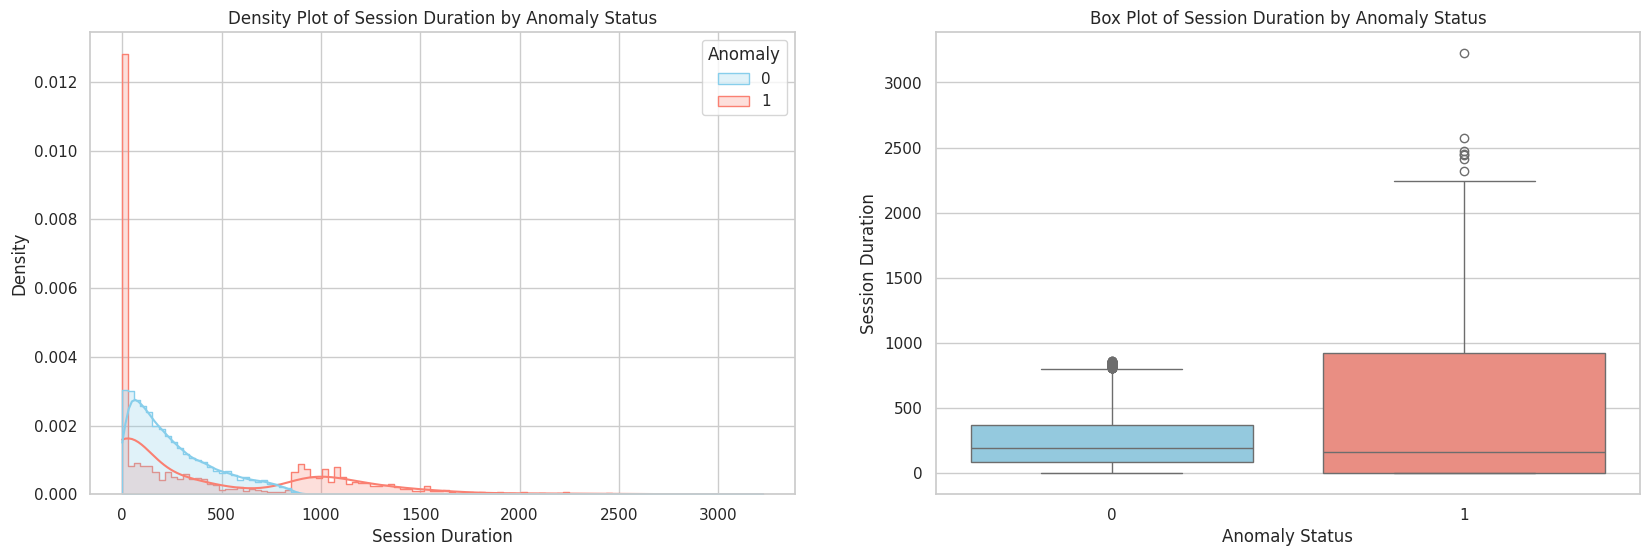

/tmp/ipython-input-903842323.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


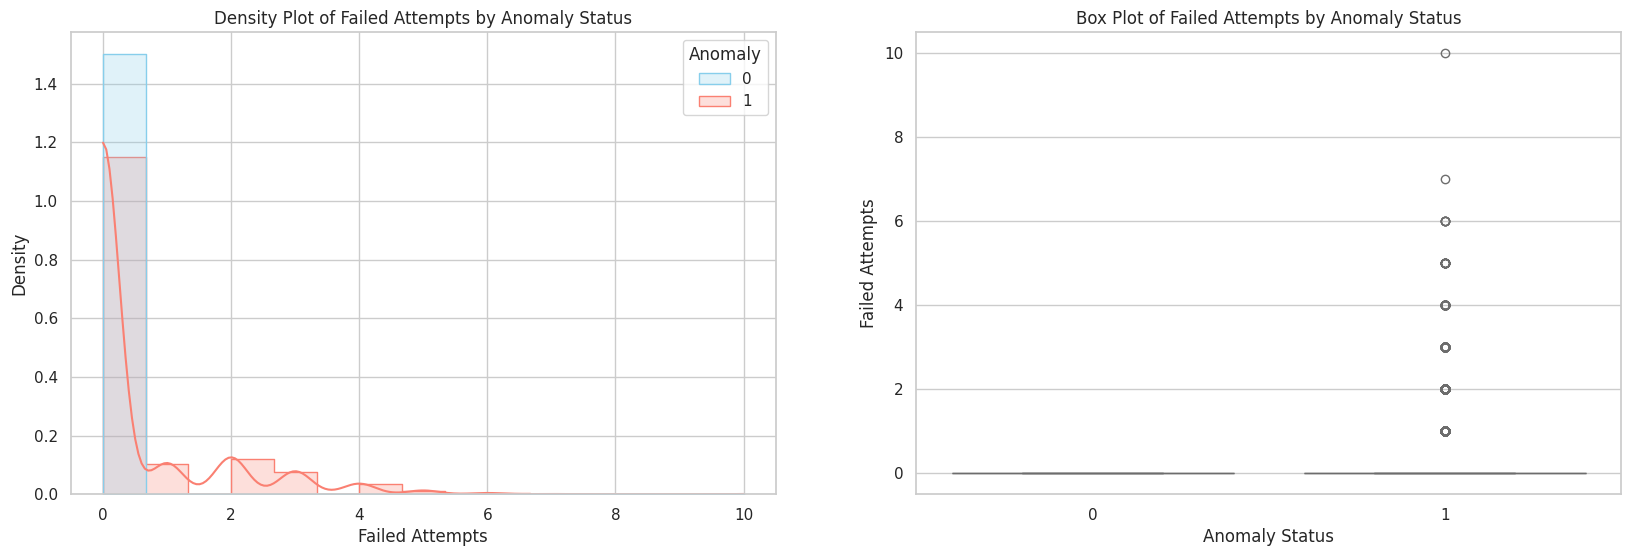

/tmp/ipython-input-903842323.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})


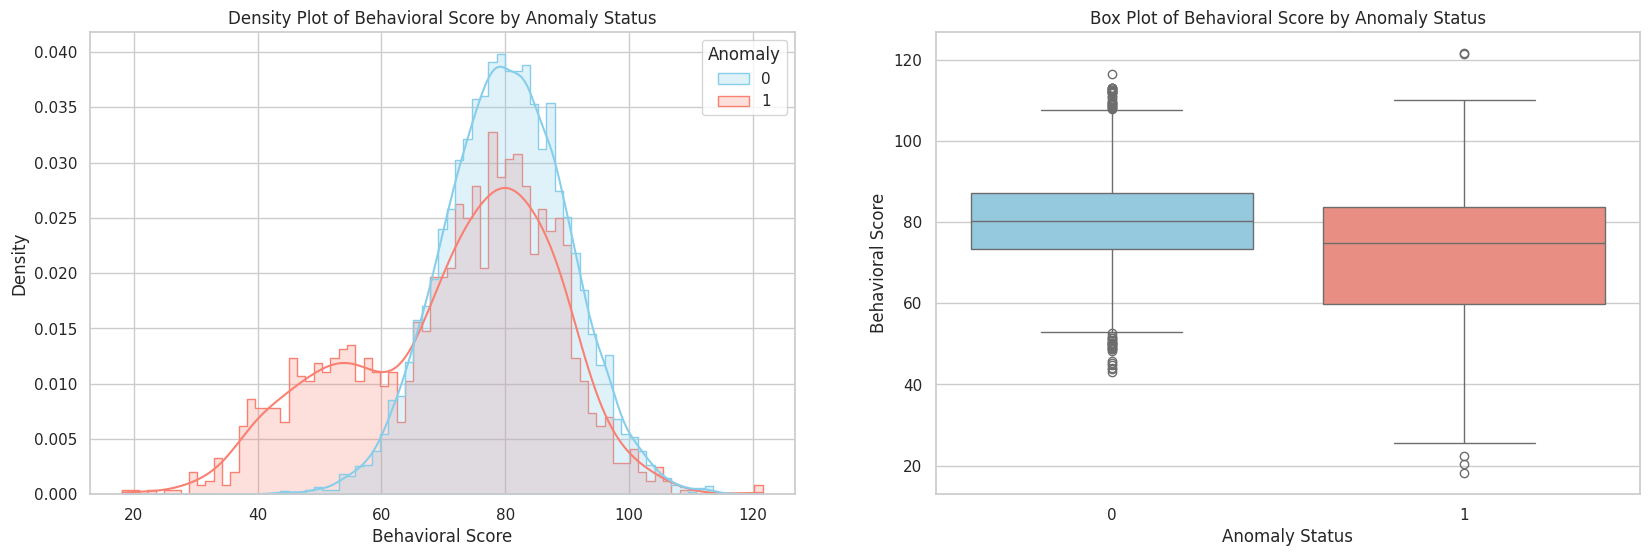

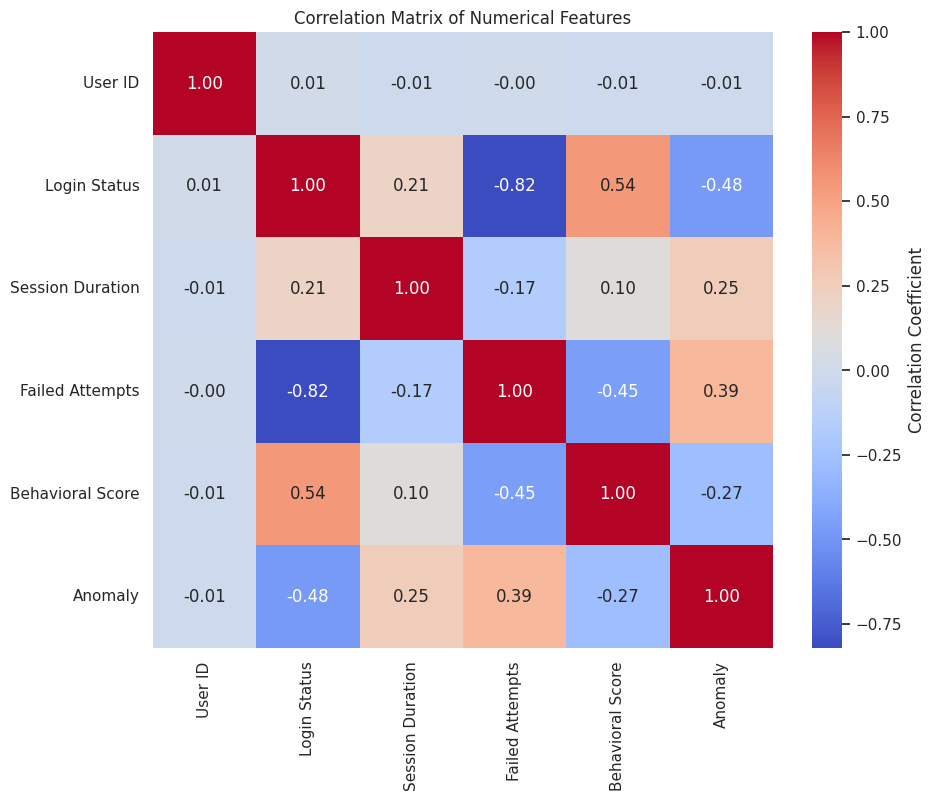

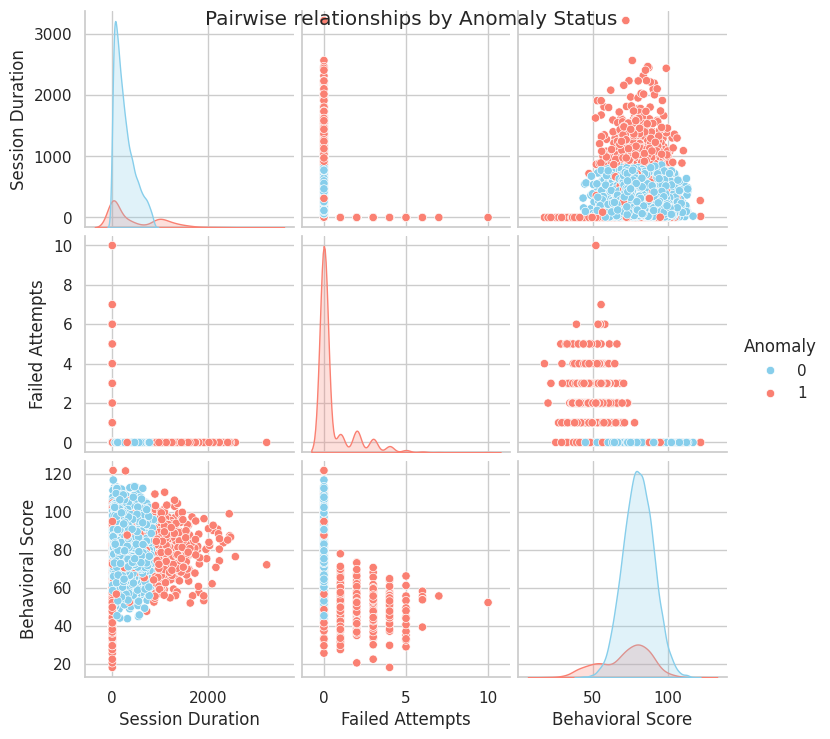

In [45]:
# Biểu đồ mật độ (Density) và biểu đồ hộp (box plots) cho các đặc điểm số theo trạng thái bất thường
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
for feature in numerical_features:
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)  # Density plot
    sns.histplot(data=df, x=feature, hue='Anomaly', element='step', stat='density', common_norm=False, kde=True, palette={0: 'skyblue', 1: 'salmon'})
    plt.title(f'Density Plot of {feature} by Anomaly Status')
    plt.xlabel(feature)
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)  # Box plot
    sns.boxplot(x='Anomaly', y=feature, data=df, palette={'0': 'skyblue', '1': 'salmon'})
    plt.title(f'Box Plot of {feature} by Anomaly Status')
    plt.xlabel('Anomaly Status')
    plt.ylabel(feature)
    plt.show()

# Biểu đồ nhiệt (Heatmap) cho ma trận tương quan của các đặc điểm số
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Biểu đồ cặp (Pairplot) cho các mối quan hệ từng cặp, được phân đoạn theo trạng thái Bất thường.
sns.pairplot(df, hue='Anomaly', vars=numerical_features, palette={0: 'skyblue', 1: 'salmon'})
plt.suptitle('Pairwise relationships by Anomaly Status', verticalalignment='top')
plt.show()

# Xử lý dữ liệu

Các bước tiền xử lý khác nhau được áp dụng cho các đặc trưng số và phân loại để đảm bảo chúng được định dạng phù hợp cho các mô hình học máy.

In [46]:
# Phân loại feature
numerical_features = ['Session Duration', 'Failed Attempts', 'Behavioral Score']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Device Type', 'Location', 'Login Status', 'IP Address']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

def extract_time_features(x):
    x['hour'] = x['Timestamp'].dt.hour
    x['day_of_week'] = x['Timestamp'].dt.dayofweek
    return x[['hour', 'day_of_week']]
time_transformer = Pipeline(steps=[
    ('time_features', FunctionTransformer(extract_time_features, validate=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('time', time_transformer, ['Timestamp'])
    ])

# Chia tập dữ liệu train và test 80:20
x = df.drop('Anomaly', axis=1)
y = df['Anomaly']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
x_train_prepared = preprocessor.fit_transform(x_train)
x_test_prepared = preprocessor.transform(x_test)


In [47]:
print(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Session Duration', 'Failed Attempts',
                                  'Behavioral Score']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Device Type', 'Location', 'Login Status',
                                  'IP Address']),
                                ('time',
                                 Pipeline(steps=[('time_features',
                                                  FunctionTransformer(func=<function extract_time_features at 0x7abe6c2277e0>)),
                                                 ('scaler', StandardScaler())]),
                                 ['Timestamp'])])


# Đào tạo mô hình


## Balanced

In [48]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight = 'balanced'),
    'SVM': SVC(probability=True, class_weight = 'balanced')
}

model_predictions = {}
for name, model in models.items():
    model.fit(x_train_prepared, y_train)
    predictions = model.predict(x_test_prepared)
    probabilities = model.predict_proba(x_test_prepared)[:, 1]
    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
SVM trained successfully.


## Threshold

In [53]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight = 'balanced'),
    'SVM': SVC(probability=True, class_weight = 'balanced')
}

# Điều chỉnh threshold
threshold = 0.7

model_predictions = {}
for name, model in models.items():
    model.fit(x_train_prepared, y_train)
    predictions = model.predict(x_test_prepared)
    probabilities = model.predict_proba(x_test_prepared)[:, 1]
     # Tạo nhãn dự đoán theo threshold 0.7
    predictions = (probabilities >= threshold).astype(int)
    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
SVM trained successfully.


## C param

In [59]:
# find C for LR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Định nghĩa dải giá trị C cần thử
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Khởi tạo Logistic Regression với class_weight balanced
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

grid_search = GridSearchCV(
    log_reg,
    param_grid,
    cv=5,
    scoring='roc_auc'
)


grid_search.fit(x_train_prepared, y_train)

print("Best C:", grid_search.best_params_['C'])
print("Best CV Score:", round(grid_search.best_score_, 2))

# Lấy model tốt nhất
best_lr = grid_search.best_estimator_

# Dự đoán trên tập test
y_pred = best_lr.predict(x_test_prepared)
y_prob = best_lr.predict_proba(x_test_prepared)[:, 1]

Best C: 10
Best CV Score: 0.92


In [60]:
# find C for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Định nghĩa khoảng giá trị C muốn thử
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Khởi tạo SVM
svm = SVC(probability=True, kernel='rbf', class_weight='balanced')

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Train
grid_search.fit(x_train_prepared, y_train)

# In ra kết quả
print("Best C:", grid_search.best_params_['C'])
print("Best CV Score: {:.2f}".format(grid_search.best_score_))

Best C: 10
Best CV Score: 0.99


In [61]:
models = {
    'Logistic Regression': LogisticRegression(C=10, max_iter=1000, class_weight = 'balanced'),
    'SVM': SVC(C=10, probability=True, class_weight = 'balanced')
}

model_predictions = {}
for name, model in models.items():
    model.fit(x_train_prepared, y_train)
    predictions = model.predict(x_test_prepared)
    probabilities = model.predict_proba(x_test_prepared)[:, 1]
    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
SVM trained successfully.


## Final

In [67]:
# Final param
models = {
    'Logistic Regression': {
        'model': LogisticRegression(C=10, max_iter=1000, class_weight='balanced'),
        'threshold': 0.6
    },
    'SVM': {
        'model': SVC(C=10, probability=True, class_weight='balanced'),
        'threshold': 0.7
    }
}

model_predictions = {}

for name, config in models.items():
    model = config['model']
    threshold = config['threshold']

    model.fit(x_train_prepared, y_train)

    probabilities = model.predict_proba(x_test_prepared)[:, 1]
    predictions = (probabilities >= threshold).astype(int)

    model_predictions[name] = {
        'predictions': predictions,
        'probabilities': probabilities
    }

    print(f"{name} trained successfully")


Logistic Regression trained successfully
SVM trained successfully


# Kết quả đào tạo mô hình


Evaluation Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1653
           1       0.97      0.88      0.92       347

    accuracy                           0.97      2000
   macro avg       0.97      0.94      0.95      2000
weighted avg       0.97      0.97      0.97      2000



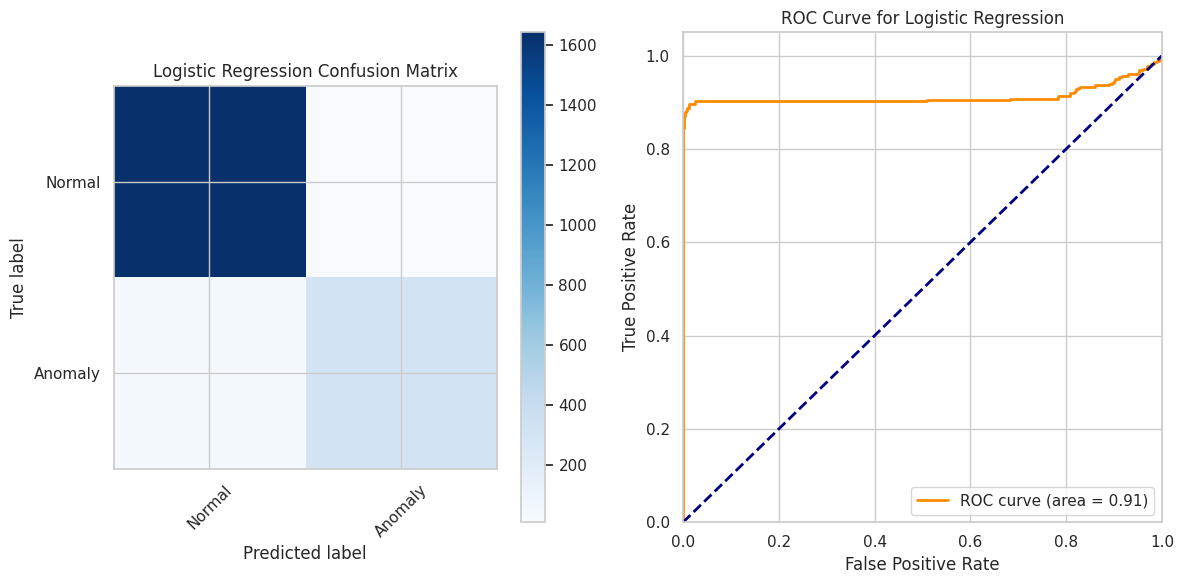

Evaluation Results for SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1653
           1       0.97      0.86      0.92       347

    accuracy                           0.97      2000
   macro avg       0.97      0.93      0.95      2000
weighted avg       0.97      0.97      0.97      2000



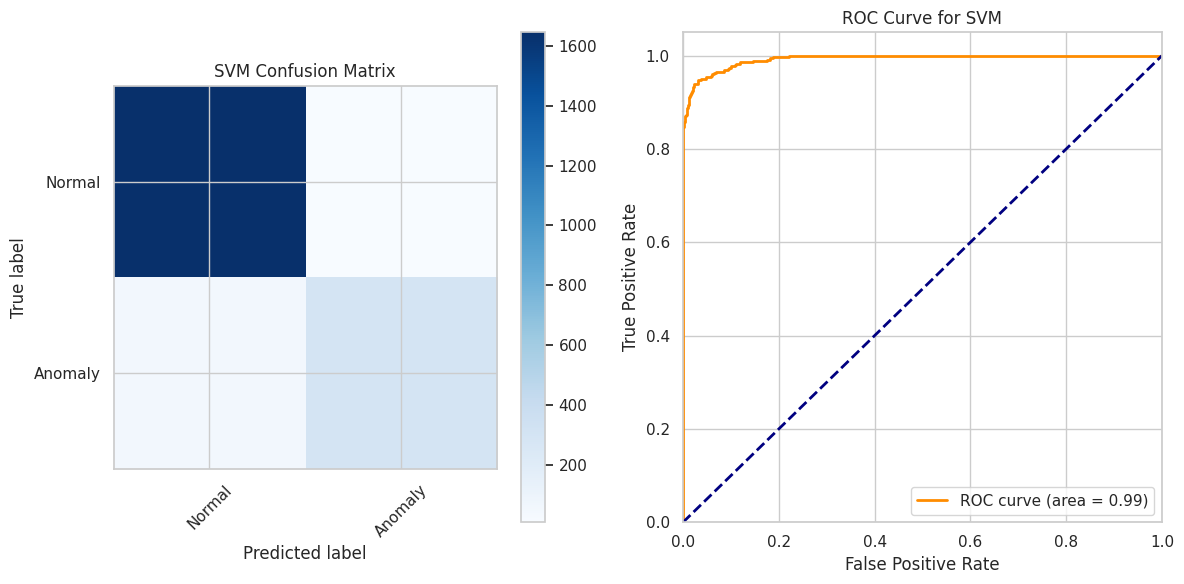

In [65]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curve(fpr, tpr, model, roc_auc):
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc="lower right")

for name, outcomes in model_predictions.items():
    print(f"Evaluation Results for {name}:")
    print(classification_report(y_test, outcomes['predictions']))
    cm = confusion_matrix(y_test, outcomes['predictions'])
    fpr, tpr, _ = roc_curve(y_test, outcomes['probabilities'])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plot_confusion_matrix(cm, classes=['Normal', 'Anomaly'], title=f'{name} Confusion Matrix')
    plot_roc_curve(fpr, tpr, name, roc_auc)
    plt.tight_layout()
    plt.show()


# Export mô hình

In [70]:
import joblib

model_files = {
    'Logistic Regression': 'logistic_regression.pkl',
    'SVM': 'svm_model.pkl'
}

for name, filename in model_files.items():
    joblib.dump(models[name]['model'], filename)
    print(f"Saved {name} to {filename}")


Saved Logistic Regression to logistic_regression.pkl
Saved SVM to svm_model.pkl
